In [1]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,matplotlib,seaborn,topicpy -a Filippo_Valle -g -r -b -w

Filippo_Valle 
last updated: Tue Jul 28 2020 

CPython 3.7.6
IPython 7.15.0

pandas 1.0.4
numpy 1.18.5
matplotlib 3.2.1
seaborn 0.10.1
topicpy 1.1.0

compiler   : GCC 7.5.0
system     : Linux
release    : 4.19.76-linuxkit
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : 0e506afd06928855c4d2cdccf9d4b792ec1e90a1
Git repo   : git@github.com:fvalle1/topics.git
Git branch : develop
watermark 2.0.2


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from topicpy.TCGA_files import *
from topicpy.gtex import get_gtex_tissue
import seaborn as sns
import sys, os
from topicpy.hsbmpy import topic_distr_isample, topic_distr_sample,get_file, get_tissue_style, get_max_available_L
from topicpy.TCGA_files import get_tcga_tissue

In [3]:
os.chdir('/home/jovyan/work/phd/topics/')

In [4]:
label=""
algorithm = "topsbm"
directory= f"{os.getcwd()}/datasets/gtex10/"
L = get_max_available_L(directory, algorithm)
os.chdir(directory)

In [5]:
df = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L))
df.head()

,i_doc,doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22
0,0,GTEX-1KWVE-2326-SM-D4P3N,0.464843,0.316693,0.151049,0.026803,0.000850,0.039762,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,GTEX-1H23P-0011-R6b-SM-A9G1H,0.433549,0.268046,0.080352,0.014057,0.000281,0.203715,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,GTEX-14C39-0011-R5b-SM-5ZZV1,0.467279,0.275826,0.116462,0.019041,0.000458,0.120934,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,GTEX-1H23P-2926-SM-9WYU8,0.463727,0.310269,0.124383,0.023467,0.000971,0.077183,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,GTEX-13N2G-0011-R10a-SM-5MR34,0.451129,0.342758,0.087319,0.016840,0.000367,0.101476,0.0,0.0,...,0.000112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Topic maps

In [6]:
l=L-1

In [7]:
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,l))
t_size = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,l), index_col=0).apply(lambda topic: sum((topic>0).astype(int))).mean()
df_files = pd.read_csv("files.dat", index_col=0).dropna(how='all', axis=0)
df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'tissue','')
df_topics.drop('i_doc', axis=1, inplace=True)
label = "SMTS"
if label not in df_files.columns:
    raise AttributeError(f"{label} not valid. Available: {df_files.columns}")
print("Working at level %d with %d topics and average size: %d"%(l,df_topics.shape[1]-1, round(t_size)))

Working at level 2 with 273 topics and average size: 11


In [8]:
for sample in df_topics.index.values:
    try:
        df_topics.at[sample,'tissue']=("%s"%(get_file(sample,df_files)[label]))
    except:
        print(*sys.exc_info())
        print(sample)
        df_topics.at[sample,'tissue']="unknown"

In [9]:
df_cmap = df_topics.sort_values(by='tissue').set_index('tissue').transpose()
df_cmap = df_cmap.subtract(df_cmap.mean(axis=1),axis=0)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

In [ ]:
cm = sns.clustermap(df_cmap, 
                    row_cluster=False, 
                    col_cluster=False, 
                    metric='euclidean',  
                    cmap='RdYlBu_r', 
                    col_colors=network_col,
                    cbar_pos=(0.95,0.8,0.05,0.2)
                    )
ax = cm.ax_heatmap

ax.tick_params(labelsize=15)
ax.set_xlabel("tissue", fontsize=35)
ax.set_title("P(topic|sample)", fontsize=25)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
#ax.set_yticklabels(df_cmap.index, rotation=0)


cax = cm.ax_cbar
cax.tick_params(labelsize=24)
cax.set_title("P", fontsize=30)
cm.fig.savefig("%s/MAP_level%d.pdf"%(algorithm,l))

### Box plots

In [10]:
def get_box_data(topic):
    box_data = []
    tissues = df_cmap.columns.unique()
    for tissue in tissues:
        df_series = df_cmap.transpose().reset_index()[["tissue",topic]]
        df_series=df_series[df_series["tissue"]==tissue]
        box_data.append(df_series[topic].values)
    return box_data, tissues

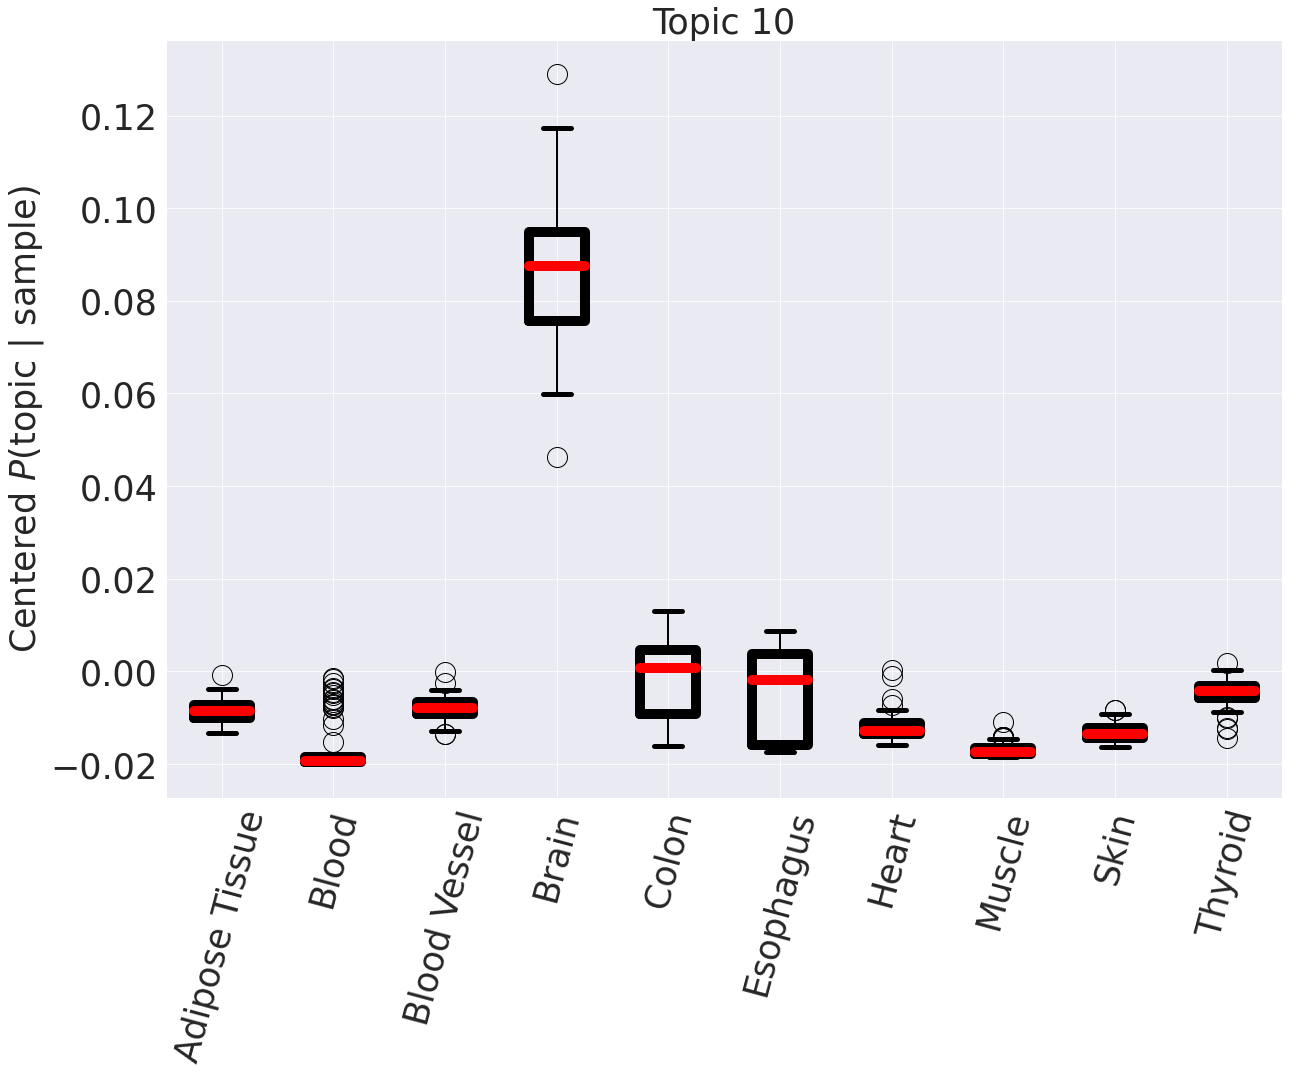

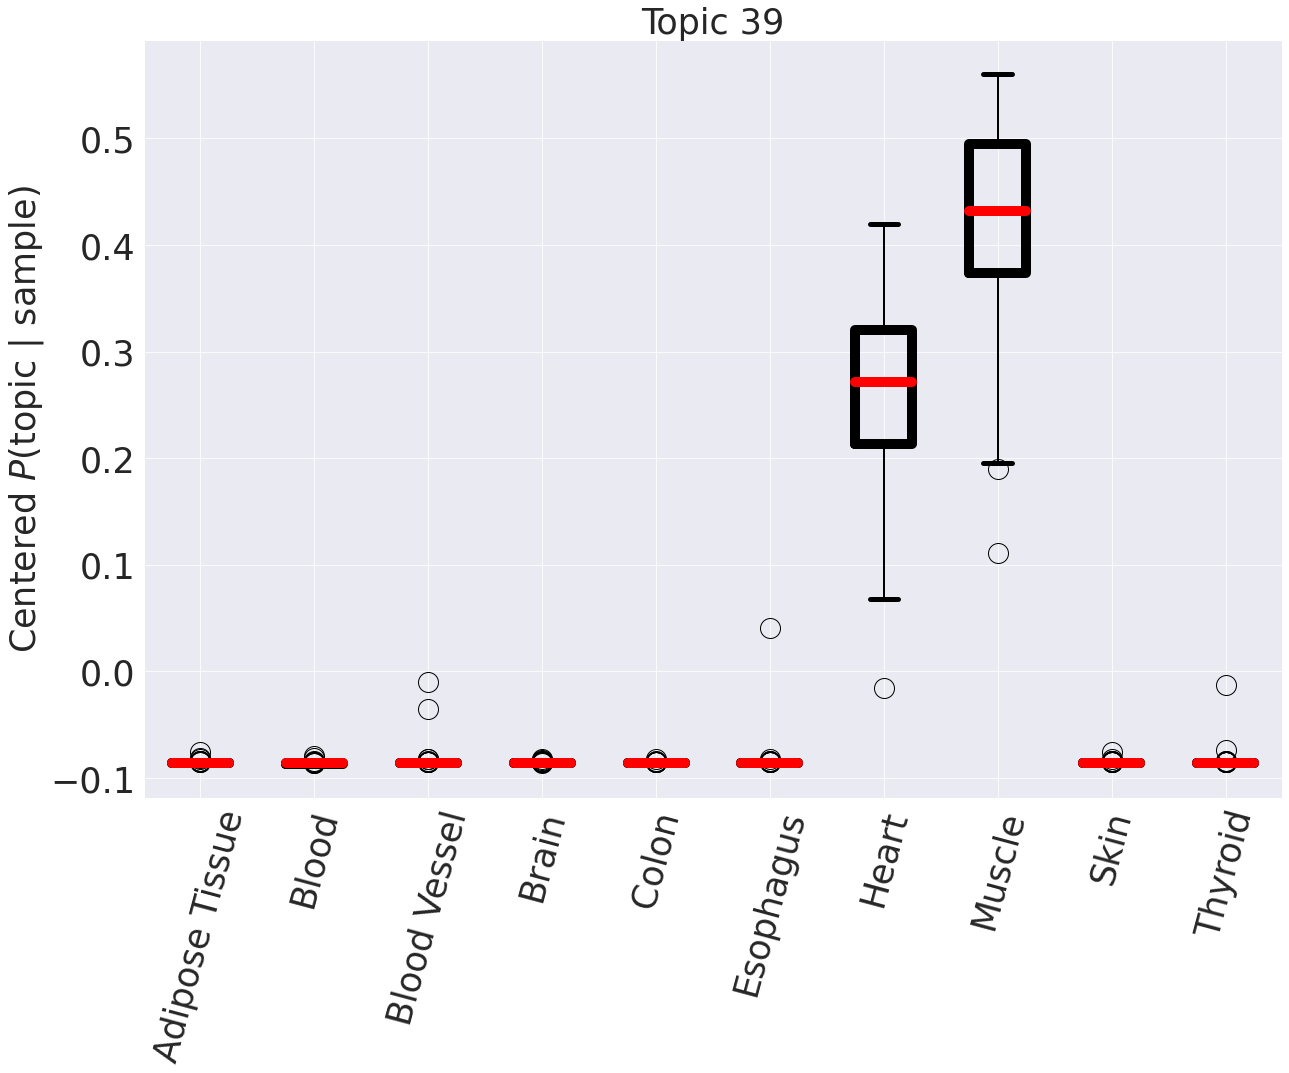

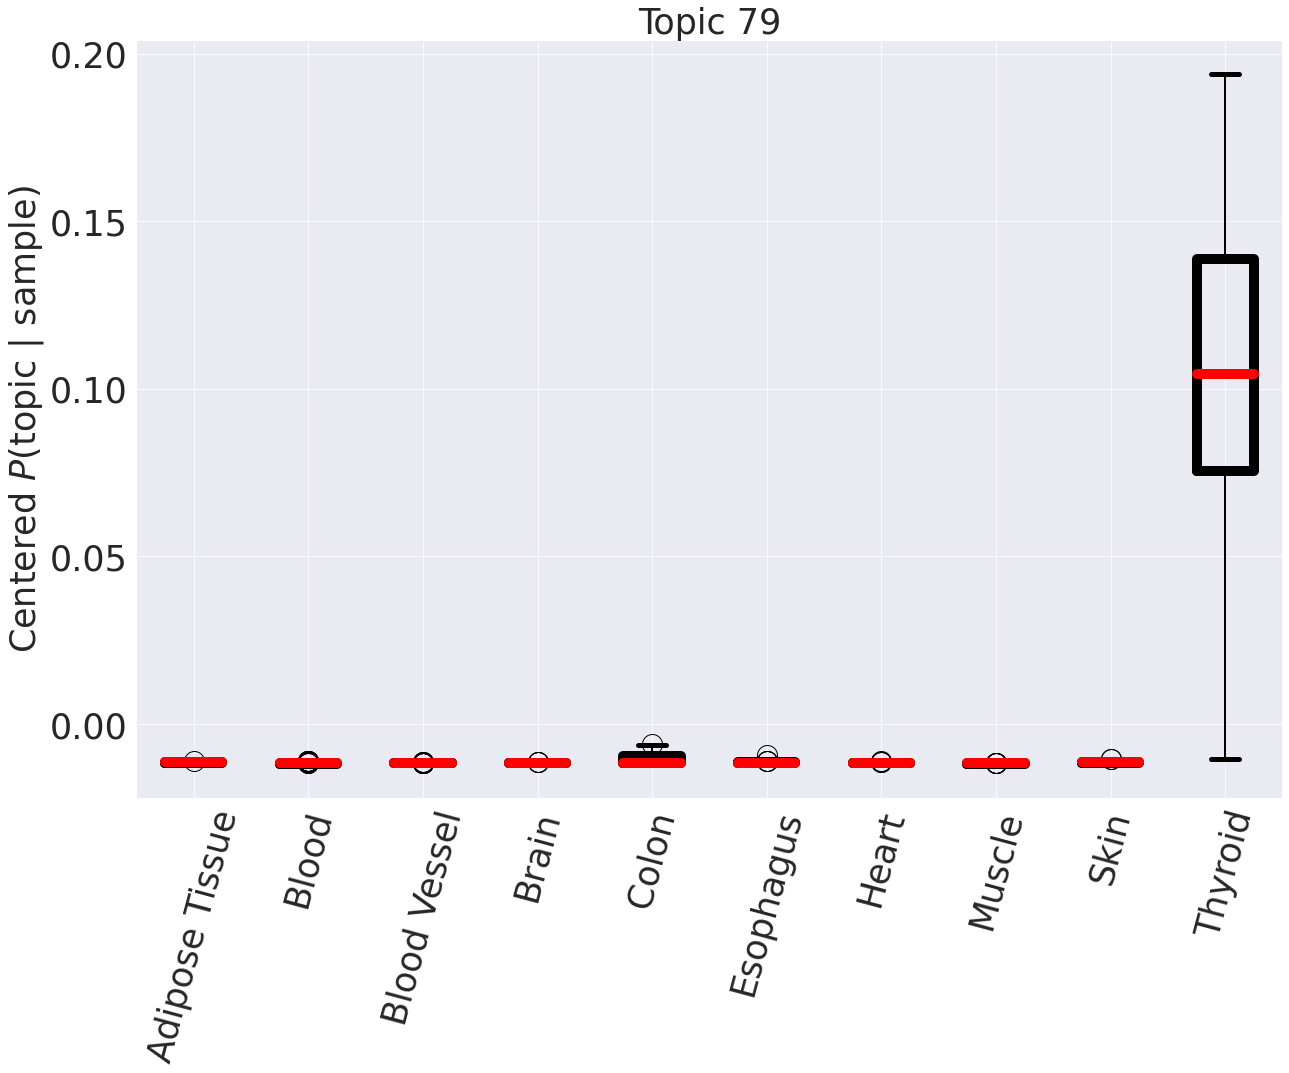

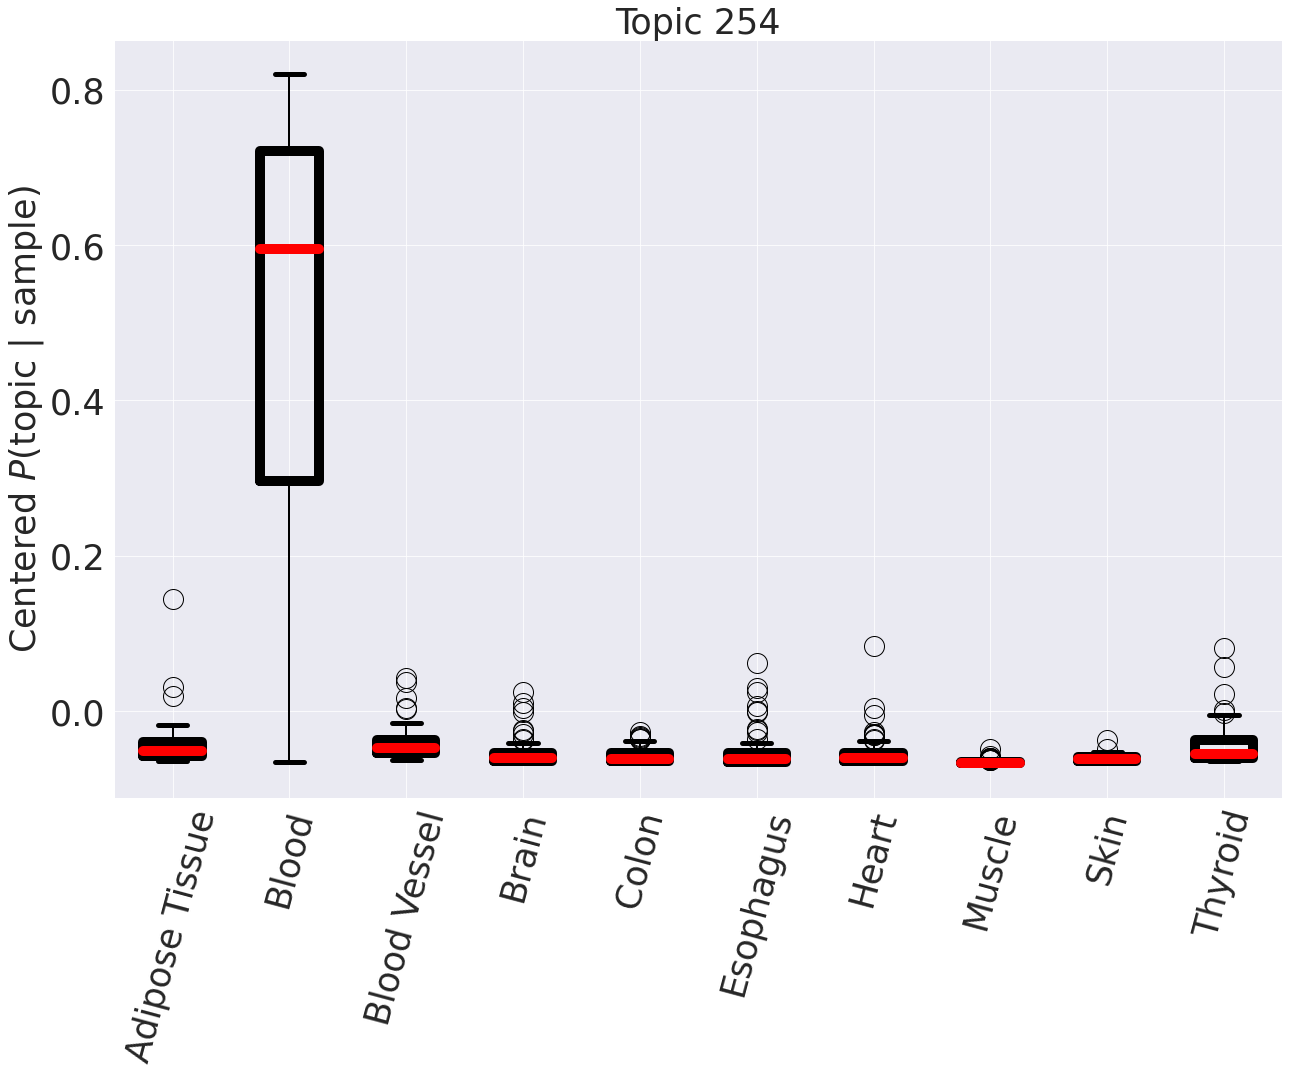

In [12]:
#for topic in df_cmap.index:
for topic in ["Topic %d"%t for t in [10,39,79,254]]:
    box_data, tissues = get_box_data(topic)
    
    Z=(np.average(box_data, axis=1).max()-np.average(box_data))/np.std(box_data)
    if Z < 1.96:
        continue

    fig, ax = plt.subplots(figsize=(18,15))
    ax.boxplot(box_data, sym="o", flierprops={"c":"gray", "ms":20, "lw":5}, boxprops = {"lw":10}, whiskerprops={"lw":2}, capprops={"lw":5}, medianprops={"c":"red", "lw":10})
    #ax.violinplot(box_data)
    
    ax.tick_params(labelsize=35)
    ax.set_title(topic, fontsize=35)

    ax.set_xticklabels(tissues, rotation = 75)
    ax.set_ylabel("Centered $P($topic $|$ sample$)$", fontsize=35)

    plt.tight_layout()
    fig.savefig(f"box_{algorithm}_{l}{topic}.pdf")
    plt.show()

In [30]:
for g in pd.read_csv("%s/%s_level_%d_topics.csv"%(algorithm,algorithm,2))["Topic 254"].dropna():
    print(g[:15])

ENSG00000244734
ENSG00000188536
ENSG00000185201
ENSG00000171223
ENSG00000213934


In [25]:
l=2
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm, algorithm,l))
df_topics.drop('i_doc', axis=1, inplace=True)
df_topics.set_index('doc', inplace=True)
order = df_topics.mean(0).sort_values(ascending=False)
df_topics = df_topics.reindex(columns=order.index)
df_topics.columns = ["Topic %d"%(t+1) for t,_ in enumerate(df_topics.columns)]
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']="%s"%(get_file(sample,df_files)[label])

Adipose Tissue
Blood
Blood Vessel
Brain
Colon
Esophagus
Heart
Muscle
Skin
Thyroid


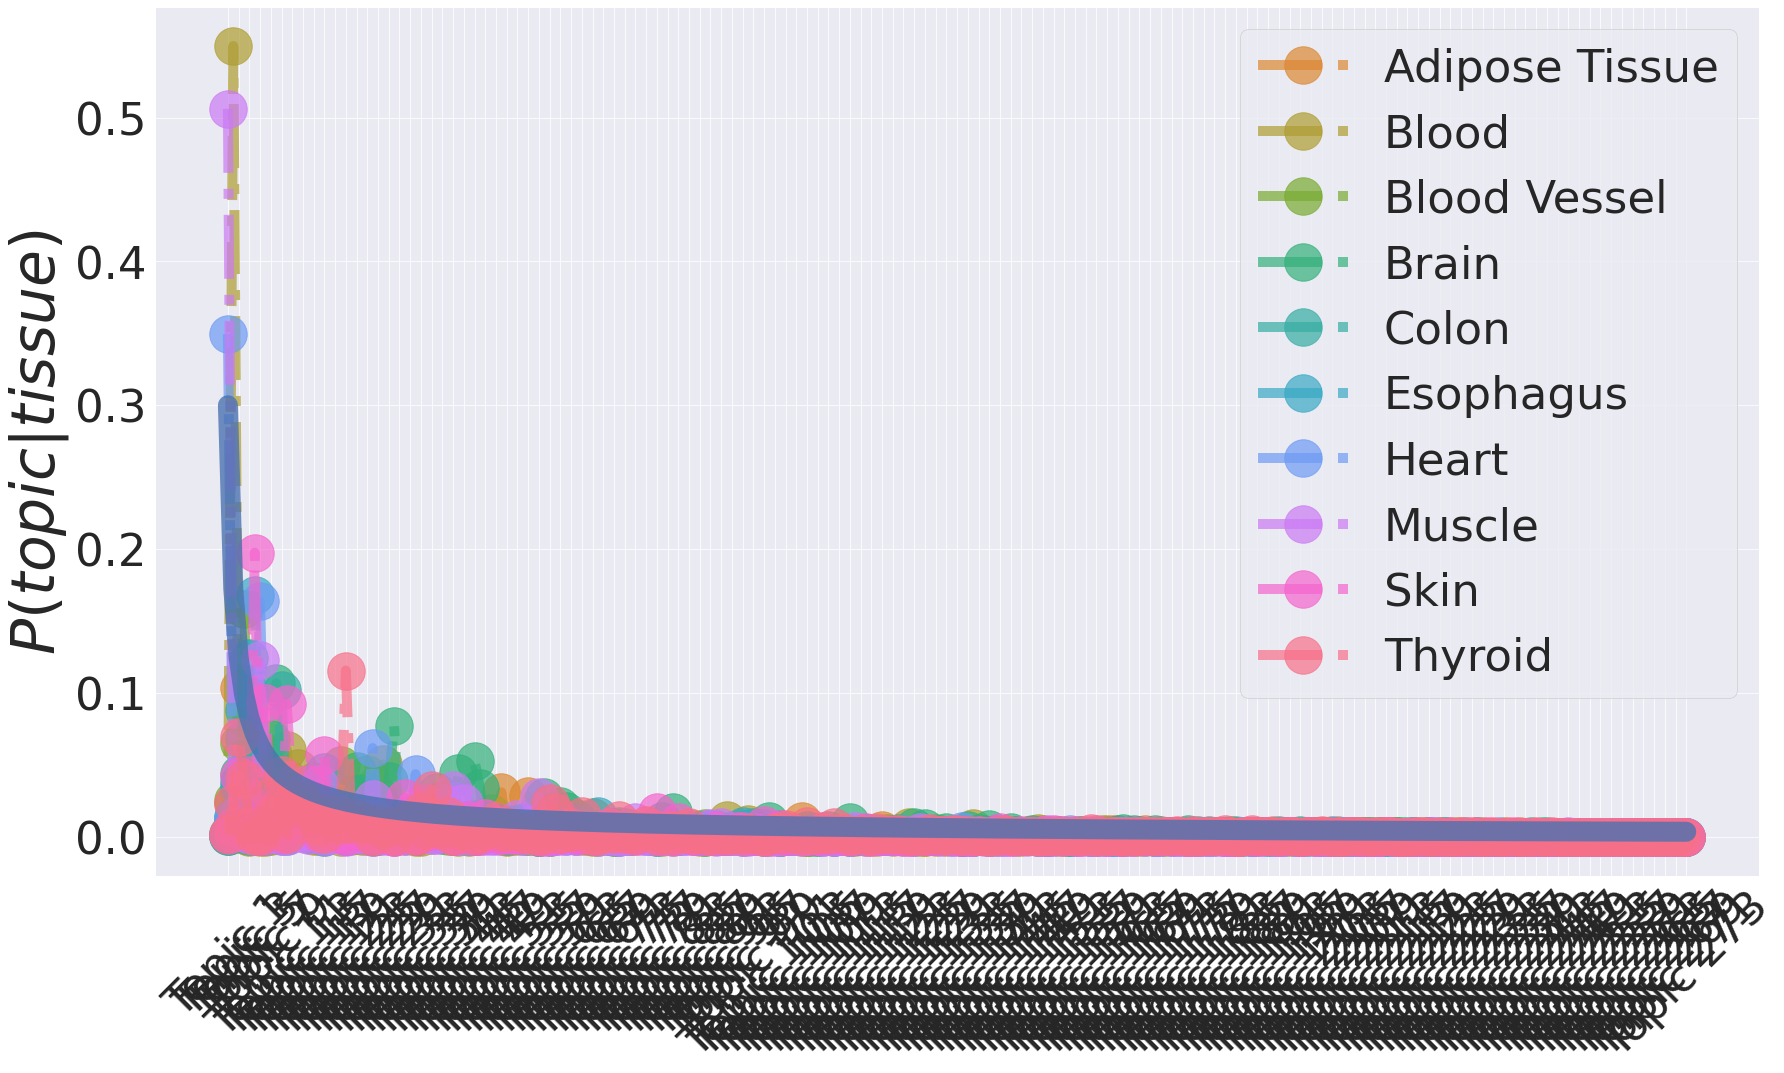

In [27]:
log = False

fig,ax = plt.subplots(figsize=(25,15))
for tissue in np.sort(df_topics['tissue'].unique()):
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    try:
        ax.plot(np.arange(1, df_topics.shape[1],step=1), df_topics[df_topics['tissue']==tissue].mean(axis=0), ls=ls,marker=marker, lw=10, ms=75, alpha=0.7,label=tissue, c=network_lut[tissue])
    except:
        print(*sys.exc_info())
ax.set_ylabel("$P(topic | tissue)$", fontsize=60)
#plt.xscale('log')
#plt.yscale('log')

if algorithm == "topsbm":
    ax.plot(np.arange(1, df_topics.shape[1],step=1),[0.3*i**-0.8 for i in np.arange(1, df_topics.shape[1],step=1)], lw=20, alpha=0.8)

ax.set_xticks(np.arange(1, df_topics.shape[1],step=2))
ax.set_xticklabels(df_topics.columns[:-1:2], rotation=45)
ax.tick_params(labelsize=45)

if log:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks(np.arange(1, df_topics.shape[1],step=1))
    ax.set_xticklabels(df_topics.columns[:-1], rotation=75)
    ax.tick_params(labelsize=40)
    ax.set_xlim(1,df_topics.shape[1])
    
    
# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(fontsize=25, ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(fontsize=45, ncol=1, loc='best')


plt.tight_layout()
plt.show()
fig.savefig("%s/lifeplot_level%d%s.pdf"%(algorithm,l,"_log" if log else ""))